# IO

In [1]:
from PineBioML import IO

In [2]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [3]:
##### Read data method 2: read multiple files
x, y = IO.read_multiple_groups(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [4]:
x.head(5)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,-0.046497,-0.936589,0.831728,0.676612,1.089821,1.182193,0.057498,1.087513,0.916977,1.366645,...,-0.906979,0.557050,-0.052619,-0.777292,1.332989,0.586623,0.755015,0.568341,0.557208,-0.301866
1,1.375768,2.982642,0.828336,0.331314,0.780520,0.077063,-0.180034,0.720076,-0.293831,1.130501,...,1.706683,0.370087,-1.770032,1.021724,-1.395205,1.358890,-0.242389,-1.181098,-1.395800,-1.978847
2,0.513176,-0.237153,0.403565,0.340722,-0.969333,1.181883,-1.853352,0.954555,0.102275,-0.966393,...,-0.287969,0.243530,-0.684112,0.179854,-1.024727,0.962608,-0.246234,-1.125735,-1.121738,-0.757847
3,-0.113984,0.570842,-1.447456,0.478515,-1.063417,-0.928786,-0.903156,-0.163331,-0.231151,0.136662,...,-0.299377,1.624747,0.046088,-0.585543,-2.059056,-0.872338,-0.491621,-0.383596,1.557598,-0.923839
4,1.338395,1.014111,-0.231040,0.188683,1.030870,0.233220,1.318331,-1.253098,-2.084681,0.360878,...,-0.284378,-0.145813,-0.264684,0.399323,0.629979,0.410857,-1.790606,-0.511627,0.539162,1.026244


In [5]:
y.value_counts()

0.0    100
1.0    100
Name: count, dtype: int64

# Preprocessing

In [6]:
from PineBioML.preprocessing import Normalizer

x = Normalizer(method="StandardScaler").fit_transform(x)

In [7]:
# Impute 0
from PineBioML.preprocessing import impute

# The imputer will drop the features with missing value more than 60%.
# Remaining will be filled by 0.
simple = impute.simple_imputer(threshold = 0.6, strategy = "constant")
x = simple.fit_transform(x)

# Data overview

In [8]:
import PineBioML.report.utils as report_utils

In [9]:
from sklearn.preprocessing import LabelEncoder
from pandas import Series

# turn y into a regression problem
y = Series(LabelEncoder().fit_transform(y), index = y.index, name = y.name)

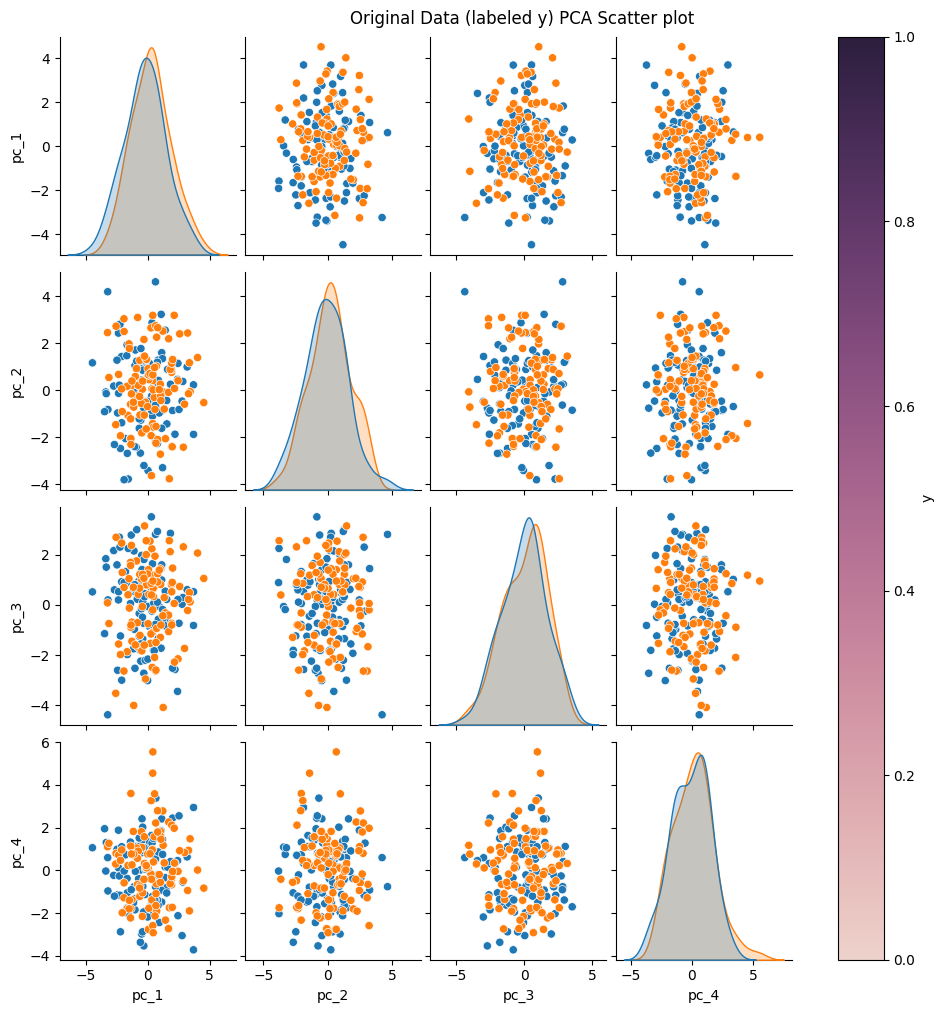

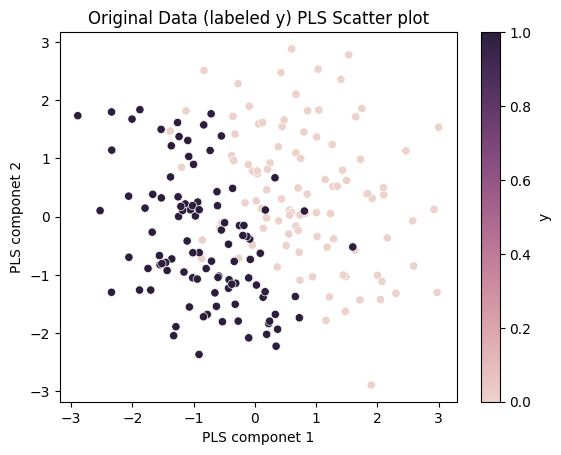

c:\Users\aimhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


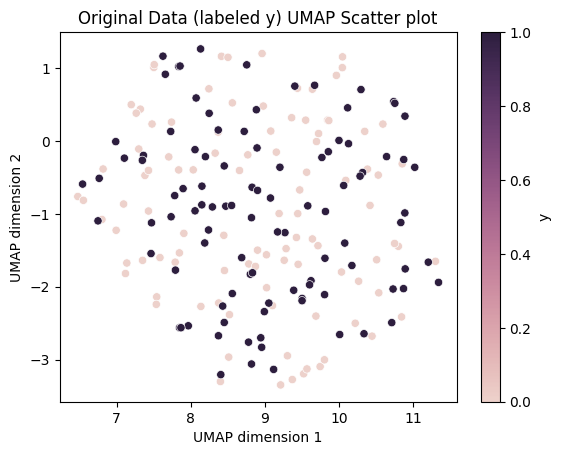

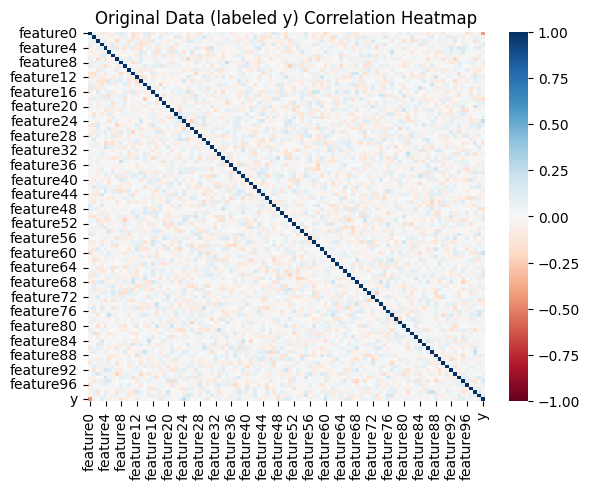

In [10]:
report_utils.data_overview(x, y, is_classification=False, discrete_legend=False, prefix="Original Data (labeled y)", save_fig=True, save_path="./output/images/", show_fig=True)

# Feature selection

In [11]:
from PineBioML.selection.regression import ensemble_selector

In [12]:
# Use several way to select top-k important features, which includes decision tree, random forest, lasso, multi lasso, svm, adaboost, xgboost
selector = ensemble_selector(k = 5)
x = selector.fit_transform(x, y) # if k = -1, it returns all the feature scores

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.



In [13]:
selector.what_matters()

,RandomForest_squared_error,LassoLinear,multi_Lasso,SVM
feature0,0.236707,0.564484,0.092477,1.0
feature47,0.033216,NaN,NaN,NaN
feature18,0.027529,NaN,NaN,NaN
feature5,0.026741,NaN,NaN,NaN
feature24,0.025891,NaN,NaN,NaN
feature63,NaN,0.564484,0.092477,1.0
feature73,NaN,0.564484,NaN,1.0
feature72,NaN,0.564484,NaN,1.0
feature71,NaN,0.564484,NaN,1.0
feature1,NaN,NaN,0.034214,NaN


# Modeling

### Train test split

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=142, shuffle=True)

### Tuning a model

In [15]:
import PineBioML.model.supervised.Regression as tuner

rf = tuner.RandomForest_tuner(target="mse", kernel_seed=11, valid_seed = 2222, optuna_seed = 333).fit(x_train, y_train)
rf.plot()

optuna seed 333  |  validation seed 2222  |  model seed 11
    RandomForest start tuning. it will take a while.
    optuna is better, best trial:  34



 rf  performance:
rmse        0.445545
r2          0.205959
mae         0.410781
support    66.000000
Name: performance, dtype: float64


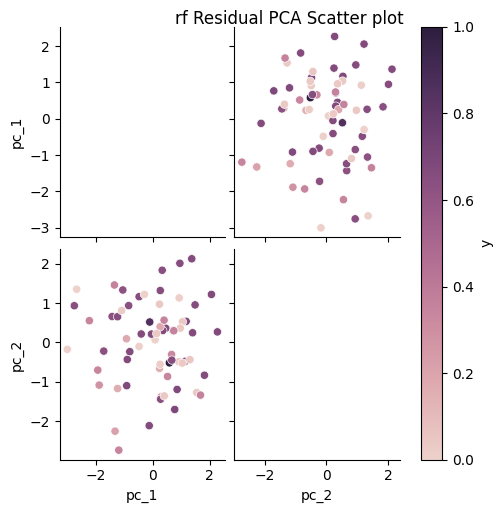

In [16]:
report_utils.regression_summary(y_valid, rf.predict(x_valid), x_valid, prefix="rf")